In [20]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy import stats
from sklearn.metrics import mean_squared_error
from objetos_rede_neural import *
from lightning.pytorch.loggers import TensorBoardLogger
import os

In [21]:
TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 0
NUM_EPOCAS = 10

In [22]:
dm = DataModule(TAMANHO_TESTE, SEMENTE_ALEATORIA)

In [23]:
logger = TensorBoardLogger(save_dir=os.getcwd(), version=1, name="lightning_logs/")
treinador = L.Trainer(logger=False,enable_checkpointing=True,max_epochs=NUM_EPOCAS)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
num_dados_de_entrada = 5
num_dados_de_saida = 1
neuronios_c1 = 10
neuronios_c2 = 20
neuronios_c3 = 10


minha_mlp = MLP(
    num_dados_de_entrada, neuronios_c1, neuronios_c2,neuronios_c3, num_dados_de_saida
)

In [25]:
treinador.fit(minha_mlp, dm)

C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory c:\Users\jose23038\OneDrive - ILUM ESCOLA DE CIÊNCIA\Semestre 3 - 2024.1\Redes-neurais-e-Algoritmos-Geneticos\Rede Neurais\Tarefas\Redes-Neurais\Principal\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 501   
---------------------------------------
501       Trainable params
0         Non-trainable params
501       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Text(0, 0.5, 'Loss')

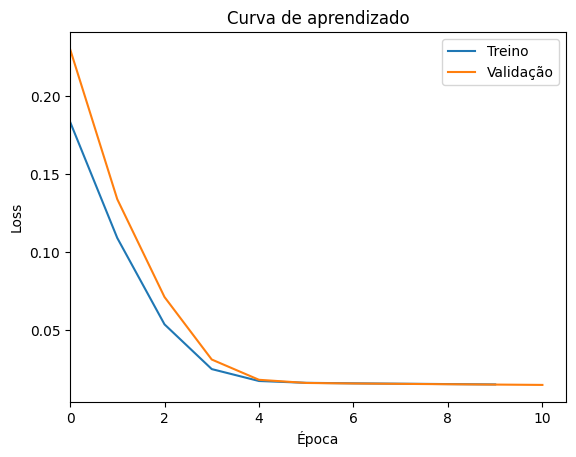

In [26]:
figura, eixo = plt.subplots()

ca_treino = minha_mlp.curva_aprendizado_treino
ca_val = minha_mlp.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

In [27]:
minha_mlp.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [28]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = dm.y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = dm.y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

274.3958101938679


C:\Users\jose23038\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
pd.read_pickle('../Conjuntos de dados/Dataset.pickle')

,Su,Sy,E,G,mu,Ro
0,421,314,207000,79000,0.3,7860
1,424,324,207000,79000,0.3,7860
2,386,284,207000,79000,0.3,7860
3,448,331,207000,79000,0.3,7860
4,441,346,207000,79000,0.3,7860
...,...,...,...,...,...,...
1539,600,370,169000,70000,0.2,7160
1540,700,420,169000,70000,0.2,7160
1541,800,480,169000,70000,0.2,7160
1542,400,180,160000,64000,0.27,7160


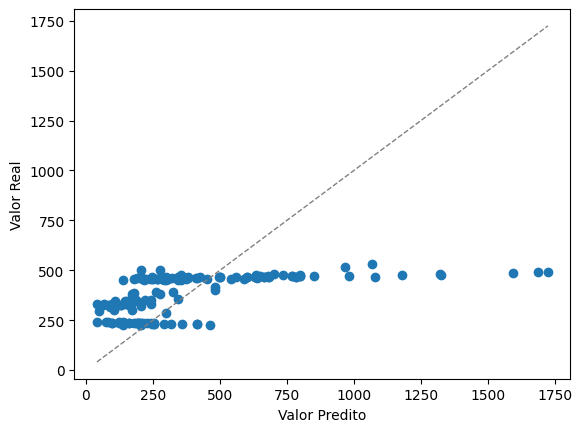

In [30]:
plt.scatter(y_true.ravel(),y_pred.ravel())
plt.ylabel("Valor Real")
plt.xlabel("Valor Predito")
_ = plt.plot([min(y_true.ravel()), max(y_true.ravel())], [min(y_true.ravel()), max(y_true.ravel())],color = 'gray',linestyle = '--',linewidth = 1)
